## Hands on lecture: train TFL net

 In this hands-on lecture, we will train a model for predicting Traffic-light (TFL) in image patches, you will use the data generated in previous course to this end.
 You will :
 1. Evaluate the data previously generated and ensure it's validity.
 2. Train a CNN 
 3. Evaluate results of the trained model.
 4. seek ways to improve results

In [1]:
%reload_ext autoreload
%autoreload 2
%autosave 120
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from os.path import join

Autosaving every 120 seconds


## Step 1. Validate your data
    use the example in the cell below, to verify the TFL patch you've generated is sane.
    Things to watch for:
    1. You are able to load and vizualize your train and val data, using the functions below.
    2. using the vizualization verify  image <--> label correspondence is correct.
    3. % Negative vs. Positive examples is aprroximately 50%
 

val :  (606, 81, 81, 3) 0/1 split 50.0 %
train :  (3366, 81, 81, 3) 0/1 split 50.0 %


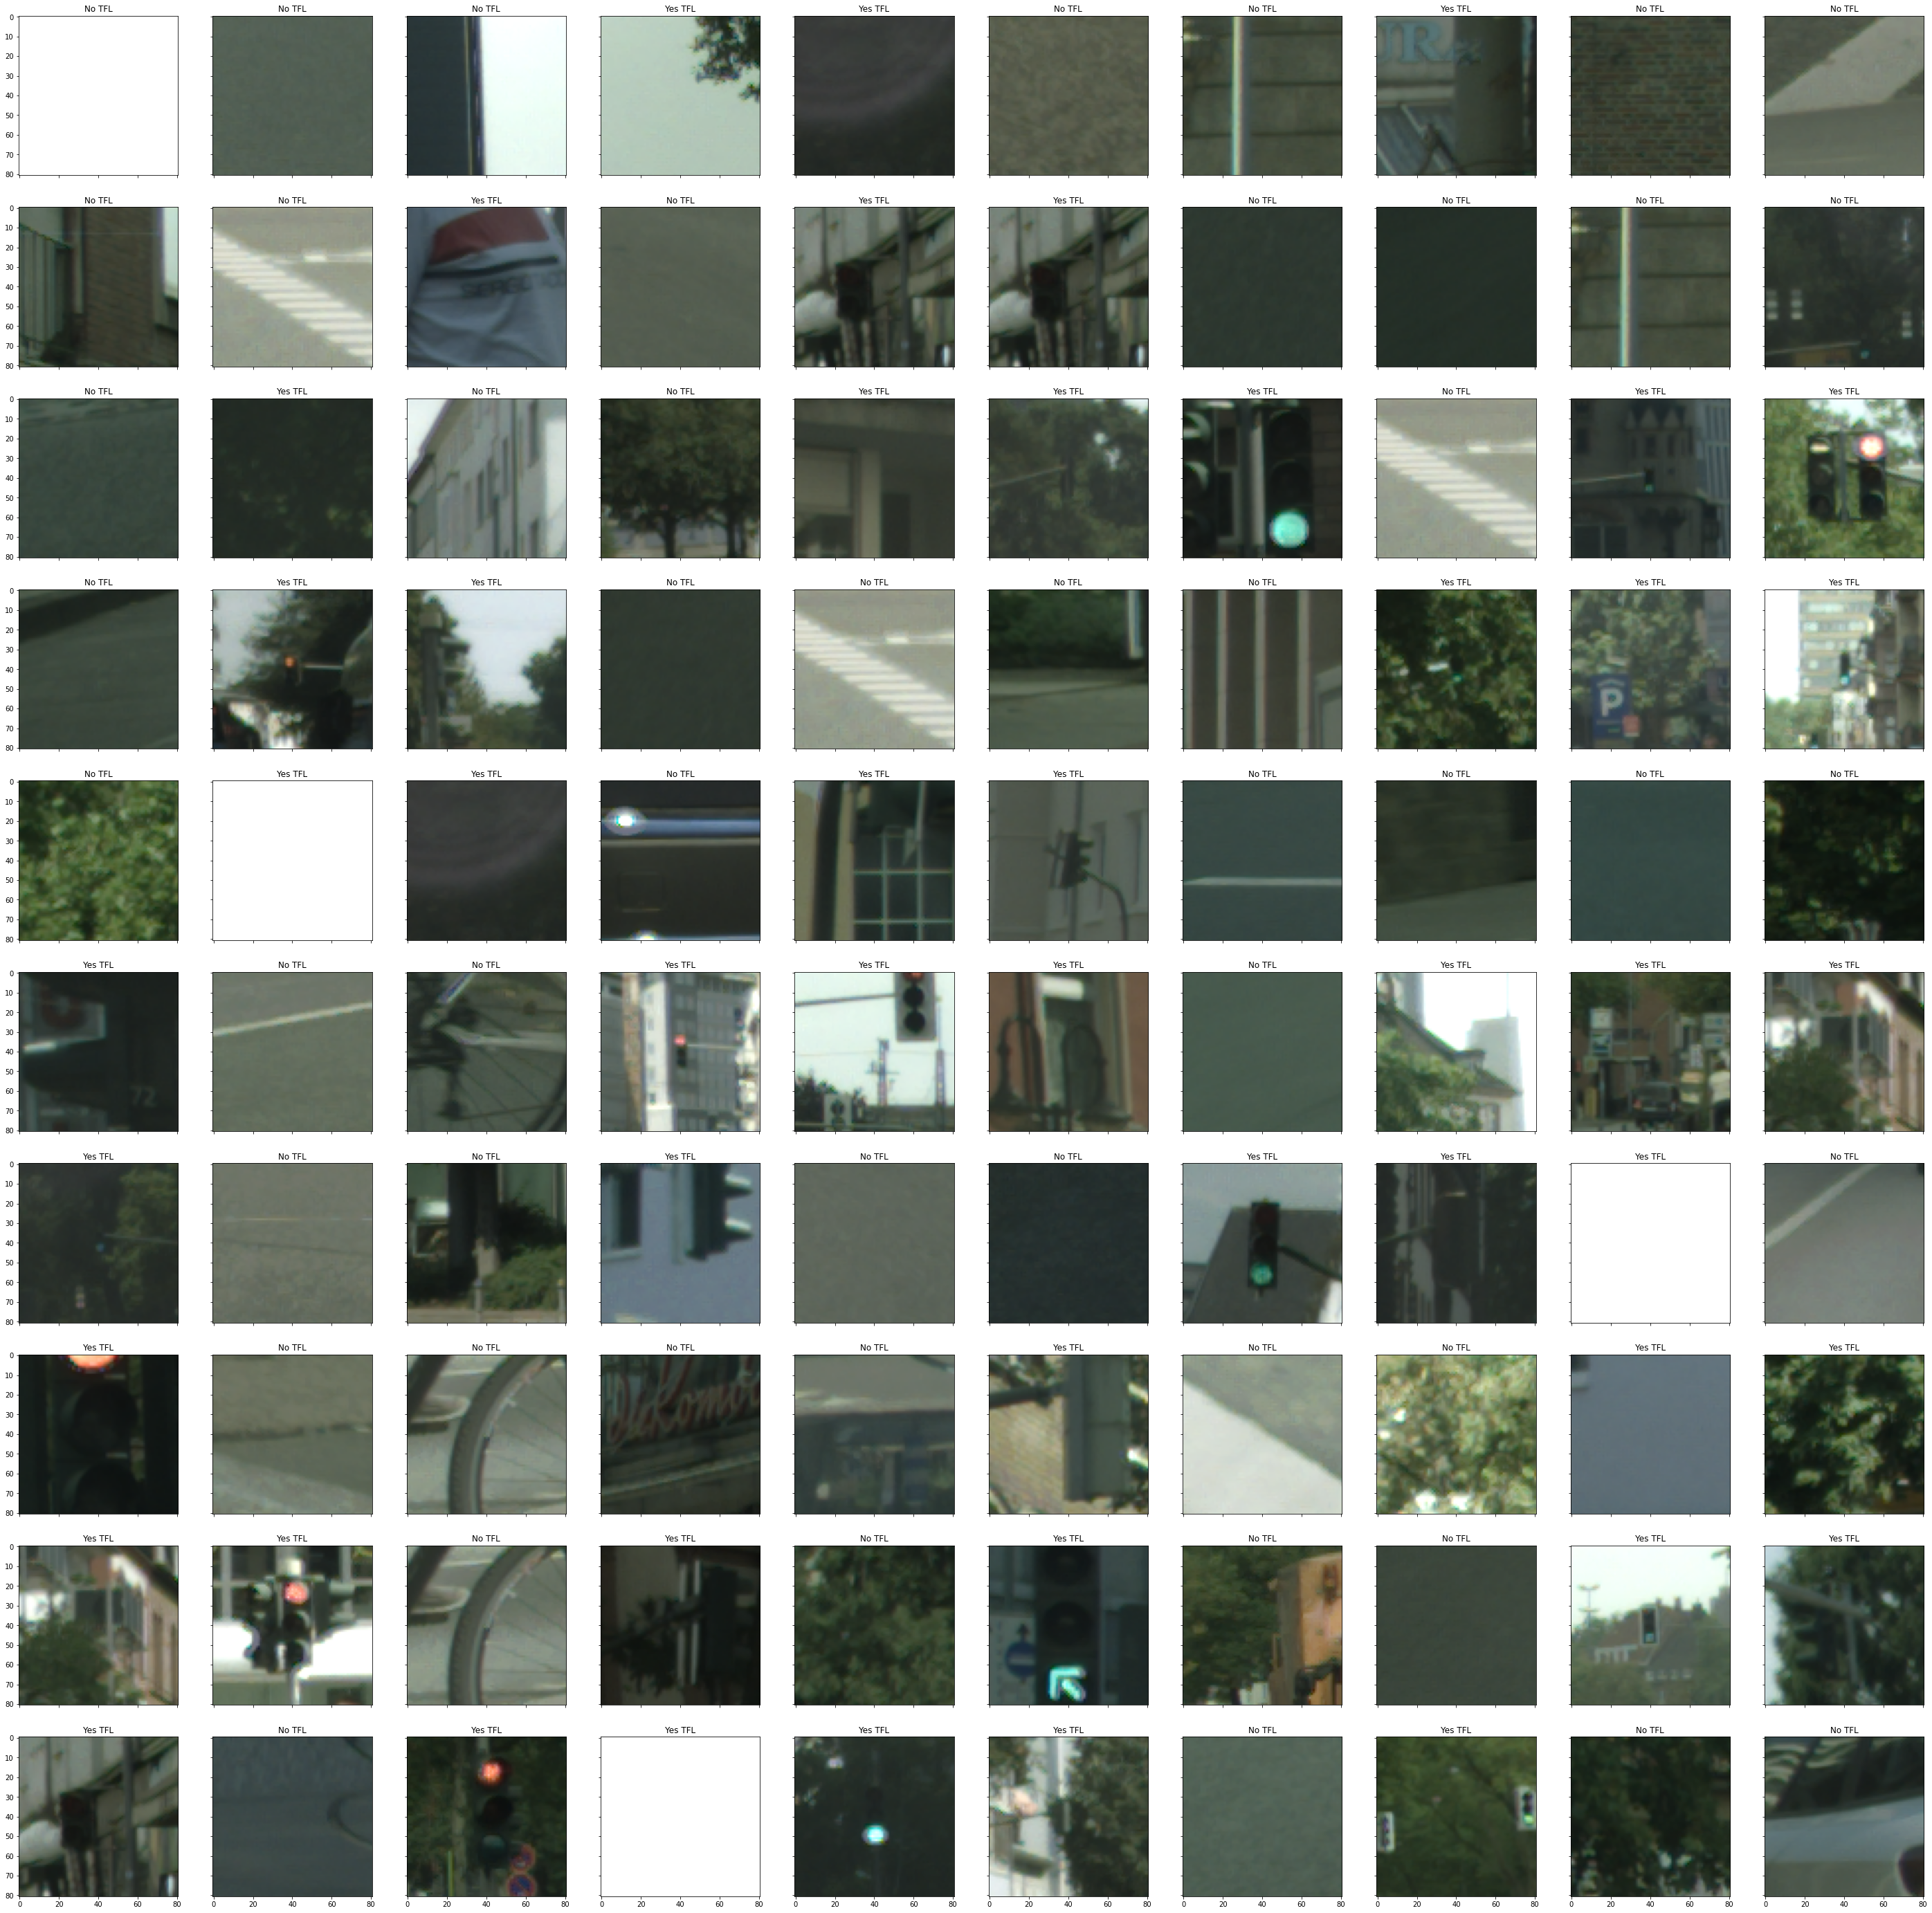

In [17]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}

def viz_my_data(images,labels, predictions=None, num=(5,5), labels2name= {0:'No TFL',1:'Yes TFL'}):
#     assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h = 5
    n = num[0]*num[1]
    ax = plt.subplots(num[0],num[1],figsize=(h*num[0],h*num[1]),gridspec_kw={'wspace':0.05},squeeze=False,sharex=True,sharey=True)[1]#.flatten()
    idxs = np.random.randint(0,images.shape[0],n)
    for i,idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None : title += ' Prediction: {:.2f}'.format(predictions[idx])
        ax.flatten()[i].set_title(title)
   

# root = './'  #this is the root for your val and train datasets
data_dir = "../../Data_dir"
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }
for k,v in datasets.items():
    
    print ('{} :  {} 0/1 split {:.1f} %'.format(k,v['images'].shape, np.mean(v['labels']==1)*100))

viz_my_data(num=(10, 10),**datasets['val'])   

## define the model used for training


In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation,MaxPooling2D,BatchNormalization,Activation, Conv2D
from tensorflow.keras import regularizers

def tfl_model():
#     input_shape =(81,81,3)
    
    model = Sequential()
    def conv_bn_relu(filters,**conv_kw):
        model.add(Conv2D(filters,  use_bias=False, kernel_initializer='he_normal',**conv_kw))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        
    def dense_bn_relu(units):
        model.add(Dense(units, use_bias=False,kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    def spatial_layer(count, filters): 
        for i in range(count):
            conv_bn_relu(filters,kernel_size=(3,3))
        conv_bn_relu(filters, kernel_size=(3,3),strides=(2,2))
    
    conv_bn_relu(32,kernel_size=(3,3),input_shape=input_shape)
    spatial_layer(1,32) 
    spatial_layer(2,64)
    spatial_layer(2,96) 
    
    
    model.add(Flatten())
    dense_bn_relu(96)
    model.add(Dense(2, activation='softmax'))
    return model
# m = tfl_model()

def my_tfl_model():
    input_shape =(81,81,3)
    
    model = Sequential()
    
#     conv_layer = Conv2D(num_filters,
#                         kernel_size=kernel_size,
#                         strides=stride,
#                         padding='same',
#                         kernel_regularizer=l2(1e-4))
    def residual_block(X, num_filters: int, stride: int = 1, kernel_size: int = 3,
                       activation: str = 'relu', bn: bool = True, conv_first: bool = True):
        
        conv_layer = Conv2D(num_filters,
                        kernel_size=kernel_size,
                        strides=stride,
                        padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))

        if conv_first:
            X = conv_layer(X)
            if bn:
                X = BatchNormalization()(X)
            if activation is not None:
                X = Activation(activation)(X)
                X = Dropout(0.2)(X)
        else:
            if bn:
                X = BatchNormalization()(X)
            if activation is not None:
                X = Activation(activation)(X)
            X = conv_layer(X)

        return X

    # depth should be 9n+2 (eg 56 or 110)
    depth =6

    # Model definition
    num_filters_in = 32
    num_res_block = int((depth - 2) / 9)

    inputs = (81,81,3)

    # ResNet V2 performs Conv2D on X before spiting into two path
    X = residual_block(X=inputs, num_filters=num_filters_in, conv_first=True)

    # Building stack of residual units
    for stage in range(3):
        for unit_res_block in range(num_res_block):
            activation = 'relu'
            bn = True
            stride = 1
            # First layer and first stage
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if unit_res_block == 0:
                    activation = None
                    bn = False
                # First layer but not first stage
            else:
                num_filters_out = num_filters_in * 2
                if unit_res_block == 0:
                    stride = 2

            # bottleneck residual unit
            y = residual_block(X,
                               num_filters=num_filters_in,
                               kernel_size=1,
                               stride=stride,
                               activation=activation,
                               bn=bn,
                               conv_first=False)
            y = residual_block(y,
                               num_filters=num_filters_in,
                               conv_first=False)
            y = residual_block(y,
                               num_filters=num_filters_out,
                               kernel_size=1,
                               conv_first=False)
            if unit_res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                X = residual_block(X=X,
                                   num_filters=num_filters_out,
                                   kernel_size=1,
                                   stride=stride,
                                   activation=None,
                                   bn=False)
            X = tf.keras.layers.add([X, y])
        num_filters_in = num_filters_out

        tf.keras.applications.resnet_v2.ResNet152V2(
        include_top=True, weights='imagenet', input_tensor=None,
        input_shape=None, pooling=None, classes=1000,
        classifier_activation='softmax'
    )
        
        
        
        

     # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = AveragePooling2D(pool_size=8)(X)
    y = Flatten()(X)
    y = Dense(512, activation='relu')(y)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)

    outputs = Dense(num_classes,
                    activation='softmax')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)

# m.summary()

## train

In [77]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD
data_dir = '../../Data_dir'
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }
#prepare our model
m = my_tfl_model()
m.compile(optimizer=Adam(),loss =sparse_categorical_crossentropy,metrics=['accuracy'])

train,val = datasets['train'],datasets['val']
#train it, the model uses the 'train' dataset for learning. We evaluate the "goodness" of the model, by predicting the label of the images in the val dataset.
history = m.fit(train['images'], train['labels'], validation_data=([val['images']],[val['labels']]), epochs = 4)

ValueError: Layer conv2d_82 expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor: shape=(), dtype=int32, numpy=81>, <tf.Tensor: shape=(), dtype=int32, numpy=81>, <tf.Tensor: shape=(), dtype=int32, numpy=3>]

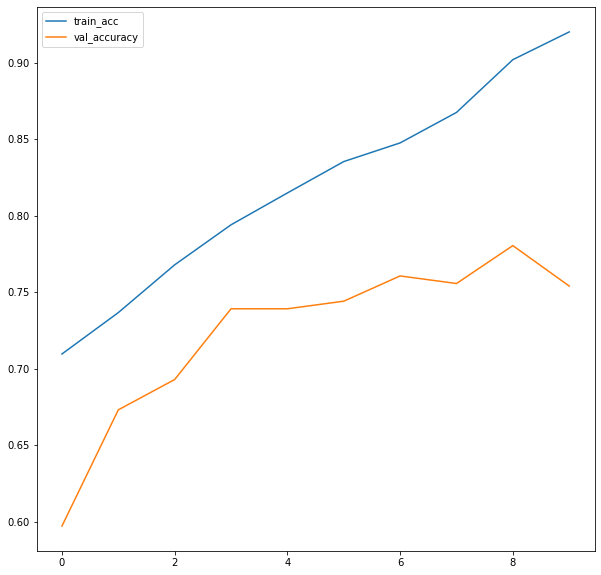

In [52]:
#compare train vs val acccuracy, 
# why is val_accuracy not as good as train accuracy? are we overfitting?
epochs = history.history
epochs['train_acc'] = epochs['accuracy']
plt.figure(figsize=(10,10))
for k in ['train_acc','val_accuracy']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)

plt.legend();

## evaluate and predict
Now thet we have a model we can use to predict results on the validation dataset.
1. What can say about example that fail prediction? can we find patterns that are common for failure cases?

accuracy: 0.7541254125412541


c:\users\naama\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


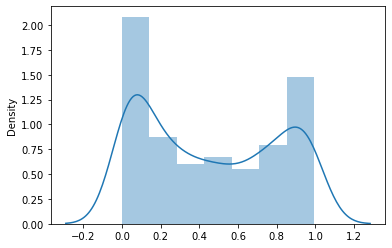

In [53]:
import seaborn as sbn
predictions = m.predict(val['images'])
sbn.distplot(predictions[:,0]);

predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

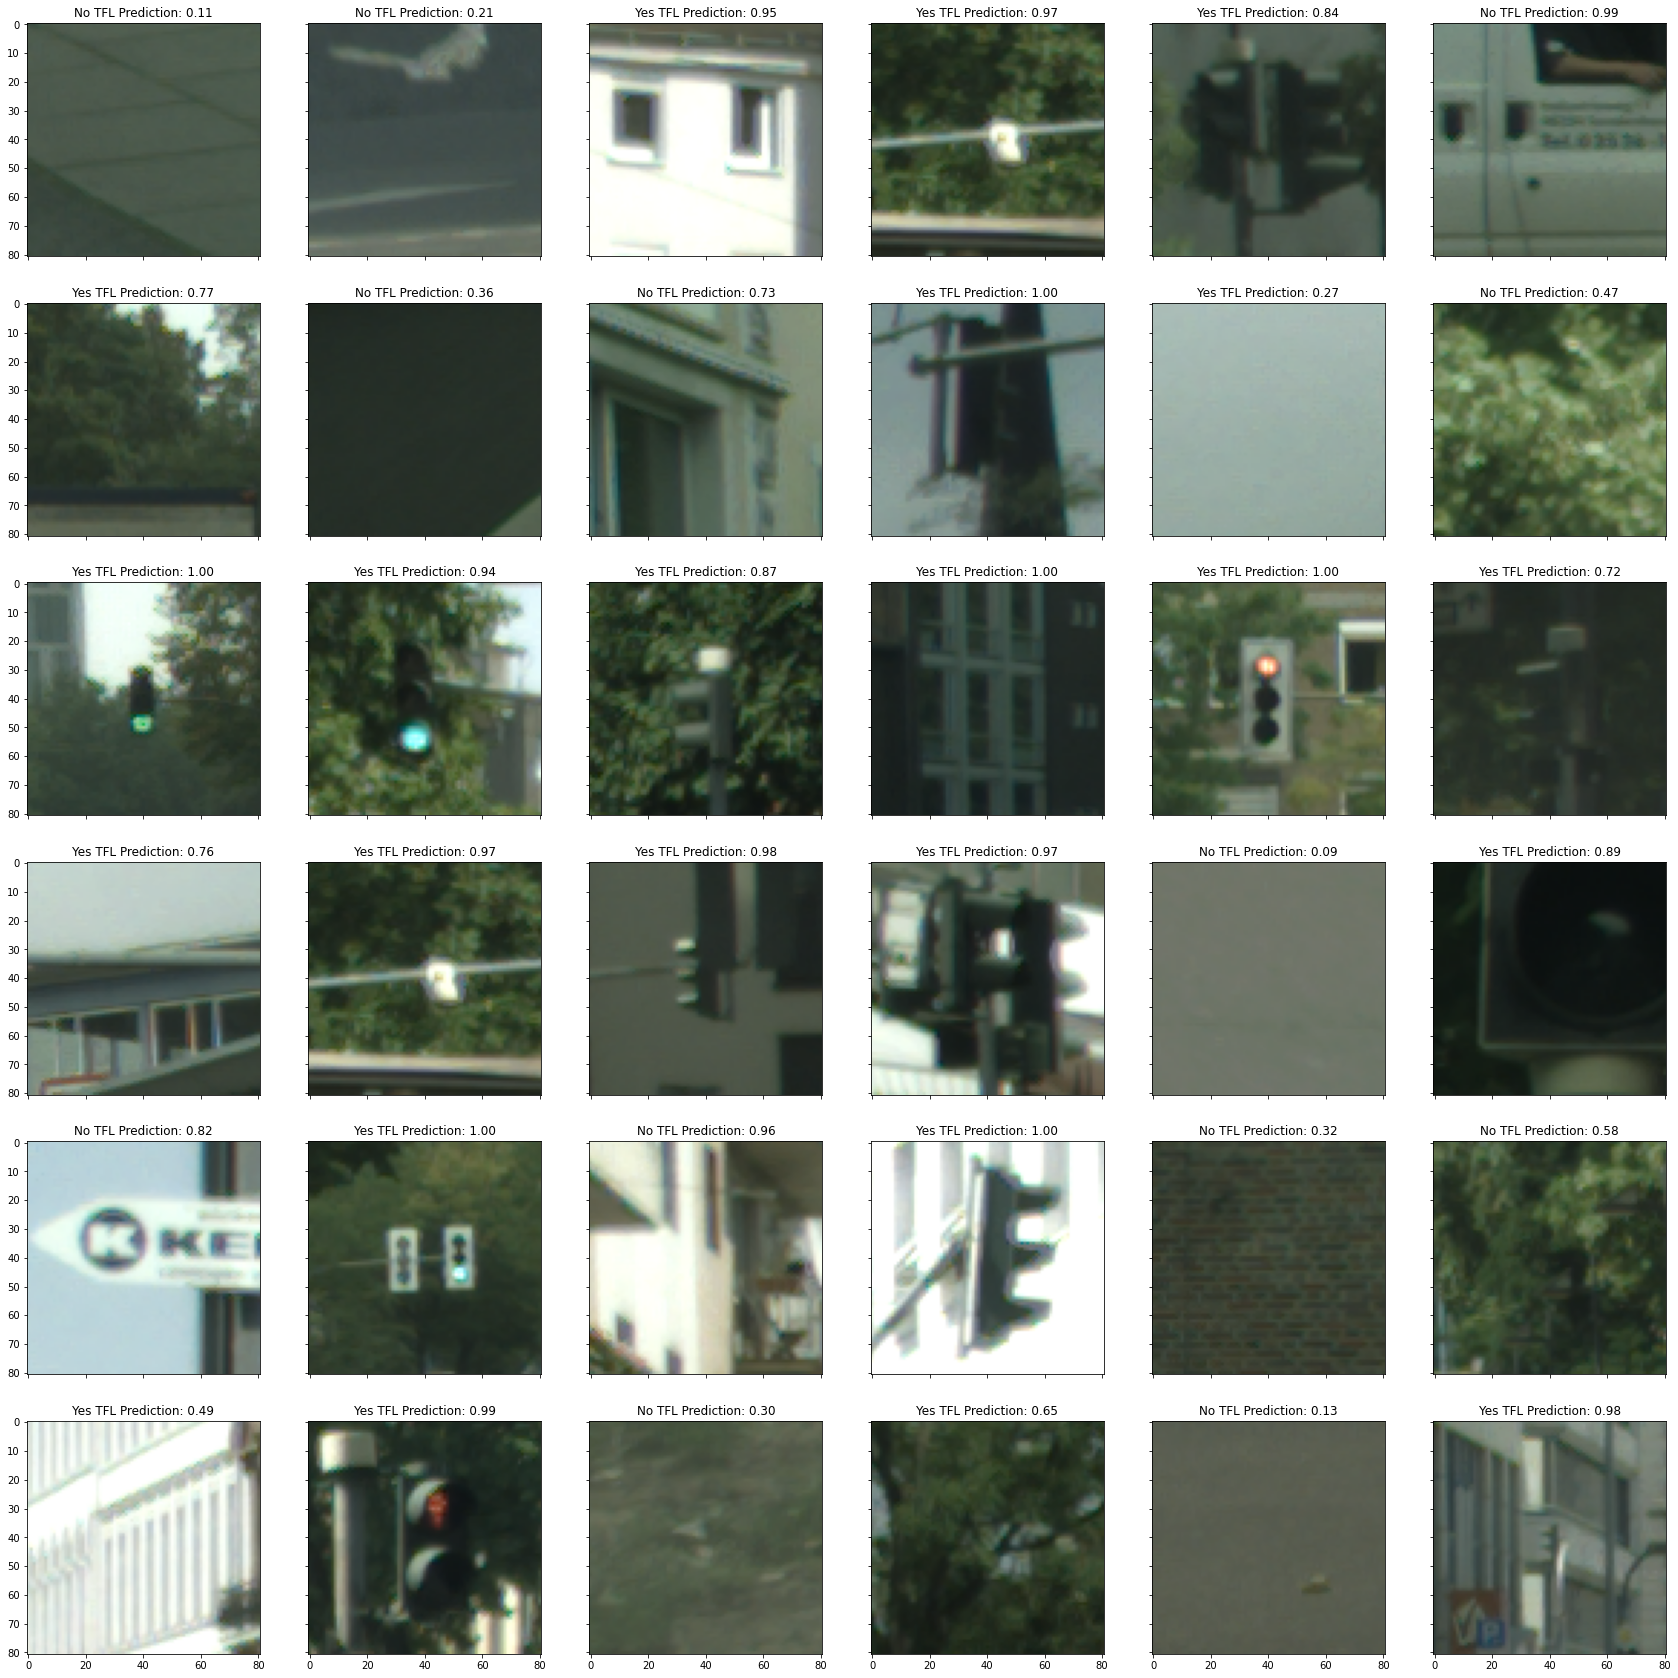

In [42]:
viz_my_data(num=(6,6),predictions=predictions[:,1],**val);

### Seek ways to improve resutls 
1. Try to play with diffferent models , increase / decrease the number of conv layers or number of  filters. you'll need to find a balanced model that is sufficiently large but minimzes overfit
    - try to enable tensorboard vizualization (see keras/ tensorboard doc) to help you carry the analysis
2. Data augmentation: feed your network with more examples by using data augmentation techniques: such as horizontal image flip, noise, etc

### Saving the model
After we trained our model and made predictions with it, we will now want to save the **architecture** together with its learned **weights** in order for us to be able to use it in the TFL manager.
The architecture will be saved as a json, the weights in the h5 format: 

In [43]:
m.save("model.h5")

In [8]:
# If you want to make sure that this model can be used on different operating systems and different
# versions of keras or tensorflow, this is the better way to save. For this project the simpler
# method above should work fine.

# json_filename = 'model.json'
# h5_filename   = 'weights.h5'
# # create a json with the model architecture
# model_json = m.to_json()
# # save the json to disk
# with open(json_filename, 'w') as f:
#     f.write(model_json)
# # save the model's weights:
# m.save_weights(h5_filename)
# print(" ".join(["Model saved to", json_filename, h5_filename]))

Model saved to model.json weights.h5


### Loading the model

In [37]:
from tensorflow.keras.models import load_model
loaded_model = load_model("model.h5")

In [101]:
# If you use the more robust method of saving above, this is how you load the model.

# with open(json_filename, 'r') as j:
#     loaded_json = j.read()

# # load the model architecture: 
# loaded_model = keras.models.model_from_json(loaded_json)
# #load the weights:
# loaded_model.load_weights(h5_filename)
# print(" ".join(["Model loaded from", json_filename, h5_filename]))

Model loaded from model.json weights.h5


accuracy: 0.7838283828382838


c:\users\naama\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


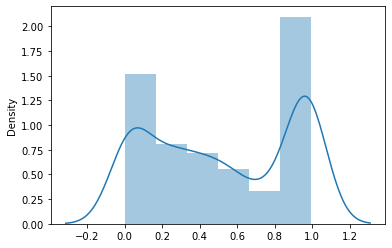

In [38]:
# code copied from the training evaluation: 
l_predictions = loaded_model.predict(val['images'])
sbn.distplot(l_predictions[:,0]);

l_predicted_label = np.argmax(l_predictions, axis=-1)
print ('accuracy:', np.mean(l_predicted_label==val['labels']))